In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import sklearn

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [3]:
df = pd.read_csv('train.csv')
pd.set_option('display.max_rows', None)

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=43)

In [5]:
train.shape, test.shape

((1168, 81), (292, 81))

# For this model we gonna keep all columns

# Cleaning

In [6]:
X = train.drop(["SalePrice", "Id"], axis=1)
y = train["SalePrice"]
X_test = test.drop(["SalePrice", "Id"], axis=1)
y_test = test["SalePrice"]

In [7]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
num_cols = [col for col in X.columns if X[col].dtype != 'object']

## CLEANING - Custom Transformer for handling missing values

In [8]:
class DealWithNans(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fill_values_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame

        for col in X.columns:
            if X[col].dtype == "object" or str(X[col].dtype).startswith("category"):
                # Categorical: use mode
                self.fill_values_[col] = X[col].mode().iloc[0]
            else:
                # Numeric: use median
                self.fill_values_[col] = X[col].median()
        
        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame
        return X.fillna(self.fill_values_)

# FEATURE ENGINEERING - Categorical encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

column_transform = ColumnTransformer([
    ("cat", cat_pipeline, cat_cols),
    ("num", "passthrough", num_cols)
])
full_pipeline = Pipeline([
    ("nan_filler", DealWithNans()),
    ("features", column_transform),
    ("model", LinearRegression())
])

# TRAINING - GridSearch with cross-validation

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Define parameter grid for hyperparameter tuning
param_grid = {
    "model__fit_intercept": [True, False]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring="r2", verbose=2)
grid_search.fit(X, y)

# Best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set using the best model
predictions_test = best_model.predict(X_test)

# Calculate test metrics
r2_test = r2_score(test["SalePrice"], predictions_test)
rmse_test = np.sqrt(mean_squared_error(test["SalePrice"], predictions_test))
mae_test = mean_absolute_error(test["SalePrice"], predictions_test)

# Output test metrics

print("\nTest Set Evaluation:")
print(grid_search.best_score_)

print("Test R² Score:", r2_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
Best Hyperparameters: {'model__fit_intercept': True}

Test Set Evaluation:
0.7917608406034615
Test R² Score: 0.8168807428243522
Te

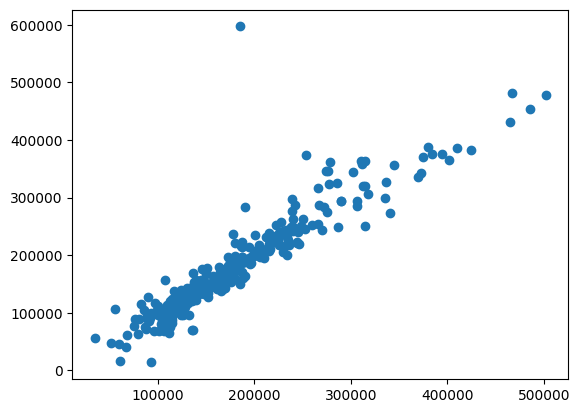

In [11]:
plt.scatter(test["SalePrice"], predictions_test)

<Axes: xlabel='SalePrice', ylabel='Count'>

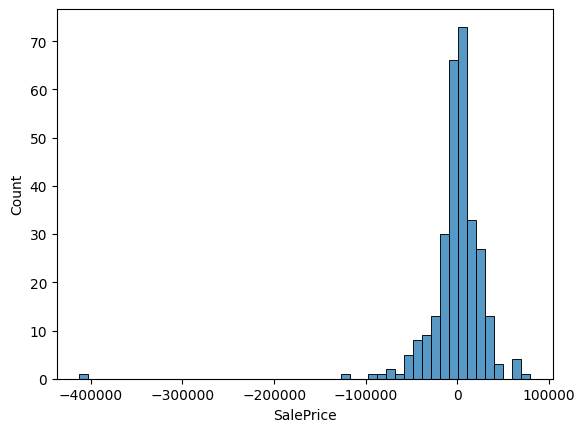

In [22]:
sns.histplot((test["SalePrice"] - predictions_test),bins=50)

In [13]:
import dagshub
dagshub.init(repo_owner='mr-master-afk', repo_name='ML-House-price-prediction', mlflow=True)

Accessing as mr-master-afk

Initialized MLflow to track repo "mr-master-afk/ML-House-price-prediction"

Repository mr-master-afk/ML-House-price-prediction initialized!

In [14]:
import mlflow

In [15]:
with mlflow.start_run(run_name="LinearRegression_with_all_columns_") as mlflow_run:
    run_id = mlflow_run.info.run_id
    print(run_id)
    
    # Log the parent experiment parameters
    mlflow.log_params({
        "cv_folds": 5,
        "scoring_metric": "r2",
        "random_state": 43,
        "model_type": "LinearRegression"
    })
    
    # Log best model and parameters as parent run artifacts
    mlflow.log_param("best_params", grid_search.best_params_)
    mlflow.log_metric("best_cv_score", grid_search.best_score_)
    mlflow.log_metric("r2_score", grid_search.best_score_)
    # Save best model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    # Create a pandas DataFrame of results
    results = pd.DataFrame(grid_search.cv_results_)

3abc9b8c45d440e2a8c73c3c491f6376
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END ..........................model__fit_intercept=True; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s
[CV] END .........................model__fit_intercept=False; total time=   0.1s


2025/04/10 22:05:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression_with_all_columns_ at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0/runs/3abc9b8c45d440e2a8c73c3c491f6376
🧪 View experiment at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0


In [16]:
X_test_prepared = test.drop(["Id", "SalePrice"], axis=1)
y_test = test["SalePrice"]

# Predict on the test set
predictions_test = best_model.predict(X_test_prepared)

# Calculate R² Score
r2_test = r2_score(y_test, predictions_test)
print("Test R² Score:", r2_test)

# Calculate RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
print("Test RMSE:", rmse_test)

# Calculate MAE
mae_test = mean_absolute_error(y_test, predictions_test)
print("Test MAE:", mae_test)

Test R² Score: 0.8168807428243522
Test RMSE: 34142.99873122279
Test MAE: 18188.54568560409
